In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ~/semantic_uncertainty/semantic_uncertainty

/home/cutter/semantic_uncertainty/semantic_uncertainty


In [3]:
import numpy as np
import random
import itertools
import umap
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import wandb

from uncertainty.data.data_utils import load_ds
from uncertainty.utils import utils
from compute_uncertainty_measures import main as main_compute

from analyze_results import analyze_run
from uncertainty.uncertainty_measures.p_ik import get_p_ik
from uncertainty.uncertainty_measures.semantic_entropy import get_semantic_ids
from uncertainty.uncertainty_measures.semantic_entropy import logsumexp_by_id
from uncertainty.uncertainty_measures.semantic_entropy import predictive_entropy
from uncertainty.uncertainty_measures.semantic_entropy import predictive_entropy_rao
from uncertainty.uncertainty_measures.semantic_entropy import cluster_assignment_entropy
from uncertainty.uncertainty_measures.semantic_entropy import context_entails_response
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentDeberta
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentGPT4
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentGPT35
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentGPT4Turbo
from uncertainty.uncertainty_measures.semantic_entropy import EntailmentLlama

In [4]:
parser = utils.get_parser()
args, unknown = parser.parse_known_args()

In [5]:
args.num_generations = 100

In [6]:
experiment_details = {'args': args}
random.seed(args.random_seed)

In [7]:
# Get accuracy metric.
metric = utils.get_metric(args.metric)

# Load dataset.
train_dataset, validation_dataset = load_ds(
    args.dataset, add_options=args.use_mc_options, seed=args.random_seed)

In [8]:
# Get indices of answerable and unanswerable questions and construct prompt.
answerable_indices, unanswerable_indices = utils.split_dataset(train_dataset)

if args.answerable_only:
    unanswerable_indices = []
    val_answerable, val_unanswerable = utils.split_dataset(validation_dataset)
    del val_unanswerable
    validation_dataset = [validation_dataset[i] for i in val_answerable]

prompt_indices = random.sample(answerable_indices, args.num_few_shot)
experiment_details['prompt_indices'] = prompt_indices
remaining_answerable = list(set(answerable_indices) - set(prompt_indices))

In [9]:
# Create Few-Shot prompt.
make_prompt = utils.get_make_prompt(args)
BRIEF = utils.BRIEF_PROMPTS[args.brief_prompt]
arg = args.brief_always if args.enable_brief else True
prompt = utils.construct_fewshot_prompt_from_indices(
    train_dataset, prompt_indices, BRIEF, arg, make_prompt)
experiment_details['prompt'] = prompt
experiment_details['BRIEF'] = BRIEF

In [10]:
# Initialize model.
model = utils.init_model(args)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
entailment_model = EntailmentDeberta()

In [21]:
# Grab example.
dataset = train_dataset
example = dataset[4]
question, context = example["question"], example['context']
generations = {'question': question, 'context': context}
correct_answer = example['answers']['text']

current_input = make_prompt(
context, question, None, BRIEF, args.brief_always and args.enable_brief)
local_prompt = prompt + current_input

In [22]:
full_responses = []

# We sample one low temperature answer on which we will compute the
# accuracy and args.num_generation high temperature answers which will
# be used to estimate the entropy variants.

num_generations = args.num_generations + 1

for i in range(num_generations):

    # Temperature for first generation is always `0.1`.
    temperature = 0.1 if i == 0 else args.temperature

    predicted_answer, token_log_likelihoods, embedding = model.predict(
        local_prompt, temperature)
    embedding = embedding.cpu() if embedding is not None else None

    # Only compute accuracy if question is answerable.
    compute_acc = args.compute_accuracy_at_all_temps or (i == 0)
    if correct_answer and compute_acc:
        acc = metric(predicted_answer, example, model)
    else:
        acc = 0.0  # pylint: disable=invalid-name

    if i == 0:
        print('question: '.ljust(15) + question)
        # if args.use_context:
        print('context: '.ljust(15) + str(context))
        print('low-t prediction: '.ljust(15) + predicted_answer)
        print('correct answer: '.ljust(15) + str(correct_answer))
        print('accuracy: '.ljust(15) + str(acc))

        most_likely_answer_dict = {
            'response': predicted_answer,
            'token_log_likelihoods': token_log_likelihoods,
            'embedding': embedding,
            'accuracy': acc}
        generations.update({
            'most_likely_answer': most_likely_answer_dict,
            'reference': utils.get_reference(example)})

    else:
        print('high-t prediction '.ljust(15) + str(i) + ' : ' + predicted_answer)
        # Aggregate predictions over num_generations.
        full_responses.append(
            (predicted_answer, token_log_likelihoods, embedding, acc))

# Append all predictions for this example to `generations`.
generations['responses'] = full_responses

question:      Who plays 'Mahmud Nasir', a Muslim who finds out he was born Jewish, in the 2010 film 'The Infidel'?
context:       producers: Omid Djalili, Cavan Ash [PAR] Director of photography: Natasha Braier [PAR] Editor: Kim Gaster[DOC] [TLE] The Infidel Reviews & Ratings - IMDbThe Infidel  Reviews & Ratings - IMDb [PAR] IMDb [PAR] 39 out of 48 people found the following review useful: [PAR] Halal/Kosher cook off [PAR] from KayWood [PAR] 8 April 2010 [PAR] I've just returned from what the organizers dubbed as "The World Premier" of 'The Infidel' at the Hammersmith Apollo, and the mere fact that the first thing on my mind is to review it should say something about this strategically mastered movie written by David Baddiel, who to my surprise can deliver an equally hilarious stand up performance. [PAR] The movie takes place in East London and it revolves around the life the Mahmud Nasir a semi-liberal Muslim family man minicab driver whose world gets disrupted by his mother's death 

In [23]:
# Compute semantic ids.
responses = [r[0] for r in full_responses]
log_liks = [r[1] for r in full_responses]
semantic_ids = get_semantic_ids(
    responses, model=entailment_model,
    strict_entailment=args.strict_entailment, example=example)

In [24]:
semantic_classes = {}
for i, response in enumerate(full_responses):
    if semantic_ids[i] not in semantic_classes:
        semantic_classes[semantic_ids[i]] = [response]
    else:
        semantic_classes[semantic_ids[i]].append(response)

In [25]:
entropies = defaultdict(list)

# Compute entropy from frequencies of cluster assignments.
entropies['cluster_assignment_entropy'].append(cluster_assignment_entropy(semantic_ids))

# Length normalization of generation probabilities.
log_liks_agg = [np.mean(log_lik) for log_lik in log_liks]

# Compute naive entropy.
entropies['regular_entropy'].append(predictive_entropy(log_liks_agg))

# Compute semantic entropy.
log_likelihood_per_semantic_id = logsumexp_by_id(semantic_ids, log_liks_agg, agg='sum_normalized')
pe = predictive_entropy_rao(log_likelihood_per_semantic_id)
entropies['semantic_entropy'].append(pe)

In [26]:
embeddings = [r[2] for r in full_responses]
embeddings = torch.stack(embeddings)
embeddings = embeddings.squeeze()

In [27]:
# Fit UMAP
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2)
X_umap = reducer.fit_transform(embeddings)

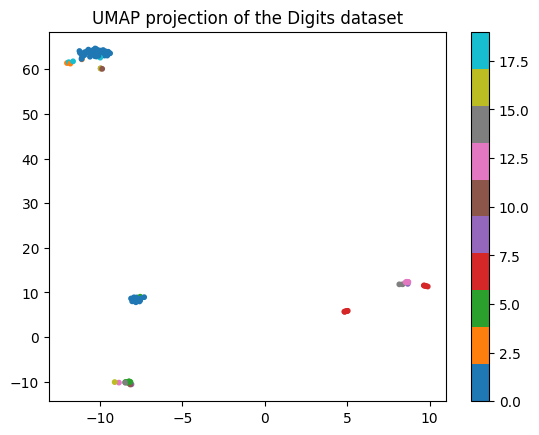

In [29]:
# Plot
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=semantic_ids, cmap='tab10', s=10)
plt.colorbar()
plt.title("UMAP projection of the Digits dataset")
plt.show()

In [20]:
similarities = []

for i, response_i in enumerate(generations['responses']):
    embedding_i = response_i[2]
    semantic_id_i = semantic_ids[i]
    for j, response_j in enumerate(generations['responses']):
        if i >= j:
            continue
        embedding_j = response_j[2]
        semantic_id_j = semantic_ids[j]